In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
import plotly.express as px
import importlib

import utility_functions as utils
importlib.reload(utils)

np.float = float
np.int = int
np.object = object
np.bool = bool

In [5]:
data_path = '../Data/pkl_data/preprocessed_df.pkl'

In [6]:
df = pd.read_pickle(data_path)

<b>Compare tempo every song with a density plot</b>

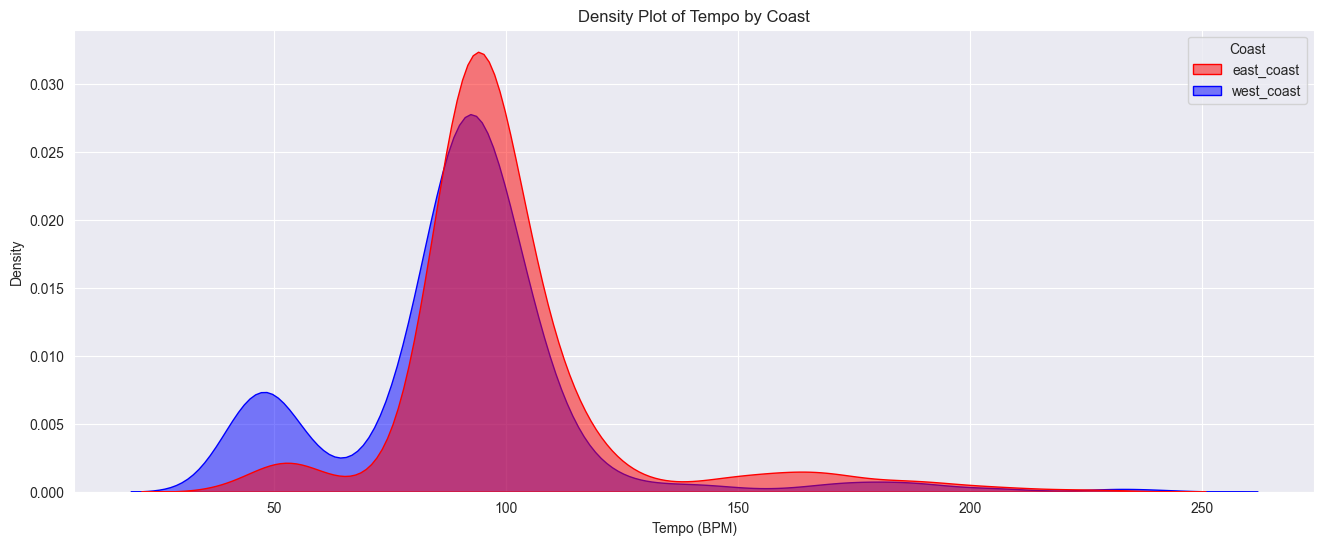

In [7]:
plt.figure(figsize=(16, 6))
sns.kdeplot(data=df, x='Tempo1', hue='Coast', fill=True, palette=['red', 'blue'], common_norm=False, alpha=0.5)

plt.title('Density Plot of Tempo by Coast')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Density')

plt.show()

<b>Compare tempo with mean energy of the different artsits</b>

In [ ]:
# Assuming df is already defined and loaded with data
only_tempo = df[['Artist', 'Coast', 'Tempo1', 'Tempo2', 'Release Year']].copy()
only_tempo.rename(columns={'Release Year': 'Release_Year'}, inplace=True)  # Renaming for consistency

years = sorted(only_tempo['Release_Year'].unique())
start_year_widget = widgets.IntSlider(min=min(years), max=max(years), value=min(years), description='Start Year:')
end_year_widget = widgets.IntSlider(min=min(years), max=max(years), value=max(years), description='End Year:')

ui = widgets.HBox([start_year_widget, end_year_widget])

def update_range(*args):
    end_year_widget.min = start_year_widget.value  # Ensure end year is always >= start year

start_year_widget.observe(update_range, 'value')

def plot_filtered_data_by_year_range(start_year, end_year):
    try:
        # Filter the DataFrame for songs released within the selected year range
        filtered_df = only_tempo[(only_tempo['Release_Year'] >= start_year) & (only_tempo['Release_Year'] <= end_year)]

        # Group by 'Artist' and 'Coast', calculate the mean for 'Tempo1'
        artist_means = filtered_df.groupby(['Artist', 'Coast']).agg({'Tempo1': 'mean'}).reset_index()

        # Sort the DataFrame by 'Tempo1' in descending order
        artist_means = artist_means.sort_values(by='Tempo1', ascending=False)

        # Create a scatter plot using Plotly Express
        fig = px.scatter(artist_means, x='Artist', y='Tempo1', color='Coast',
                         hover_name='Artist', labels={"Tempo1": "Mean Tempo (BPM)"},
                         category_orders={"Artist": sorted(filtered_df['Artist'].unique())})

        fig.update_layout(title=f'Mean Tempo by Artist (Years {start_year} to {end_year})',
                          xaxis_title='Artist',
                          yaxis_title='Mean Tempo (BPM)',
                          legend_title='Coast')
        fig.show()
    except Exception as e:
        print(f"Error: {e}")

interact(plot_filtered_data_by_year_range, start_year=start_year_widget, end_year=end_year_widget)

interactive(children=(IntSlider(value=1986, description='Start Year:', max=1998, min=1986), IntSlider(value=19…

<function __main__.plot_filtered_data_by_year_range(start_year, end_year)>

<b>Average Tempo by year and by coast</b>

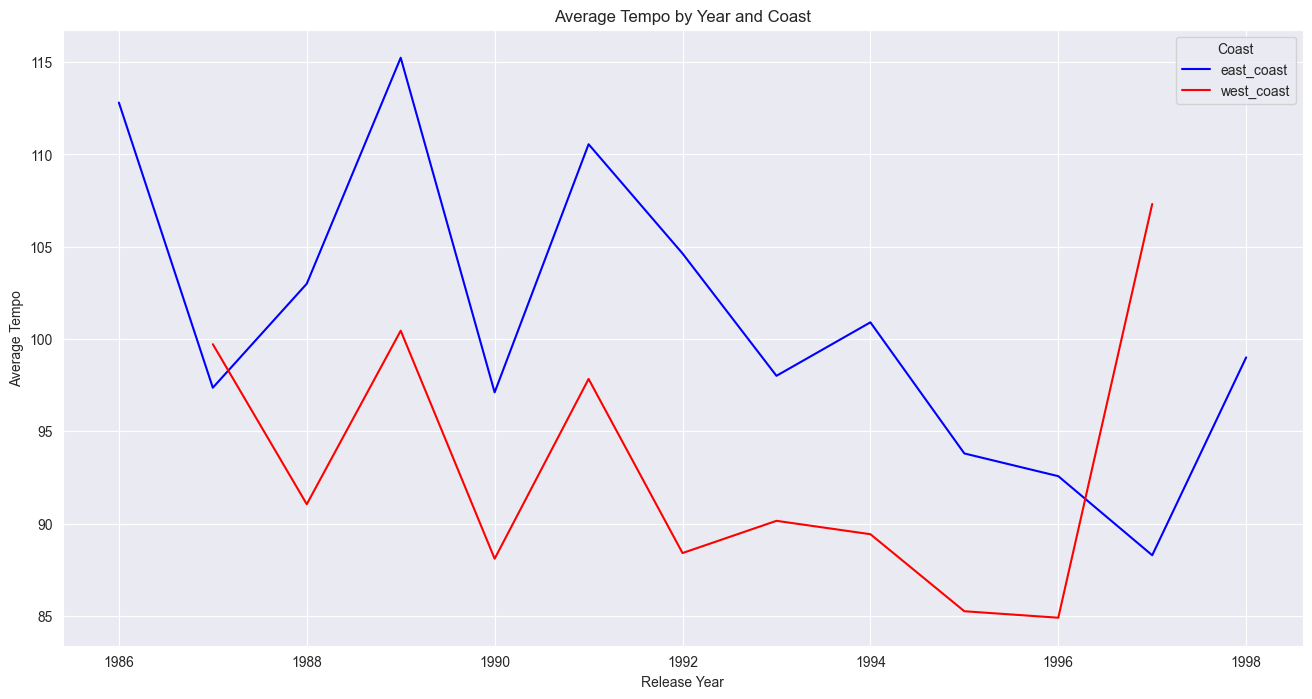

In [6]:
average_tempo = df.groupby(['Coast', 'Release Year'])['Tempo1'].mean().reset_index()

colors = {
    'east_coast': 'blue',
    'west_coast': 'red',
}

plt.figure(figsize=(16, 8))  # Width, height in inches

# Plot each coast's average tempo over the years
for coast, color in colors.items():
    # Select the subset of the data for the current coast
    subset = average_tempo[average_tempo['Coast'] == coast]

    # Ensure the data is sorted by year (important if the data isn't sorted in the dataframe)
    subset = subset.sort_values('Release Year')

    # Plotting
    plt.plot(subset['Release Year'], subset['Tempo1'], label=coast, color=color)

# Add legend, labels, and title
plt.legend(title='Coast')
plt.xlabel('Release Year')
plt.ylabel('Average Tempo')
plt.title('Average Tempo by Year and Coast')
plt.grid(True)  # Optionally add a grid for easier visualization

# Show the plot
plt.show()

<b>Average Tempo by year and topic</b>

In [13]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
df_topics = pd.read_excel('../Data/excel_data/baseline_data_w_topics.xlsx', engine='openpyxl')

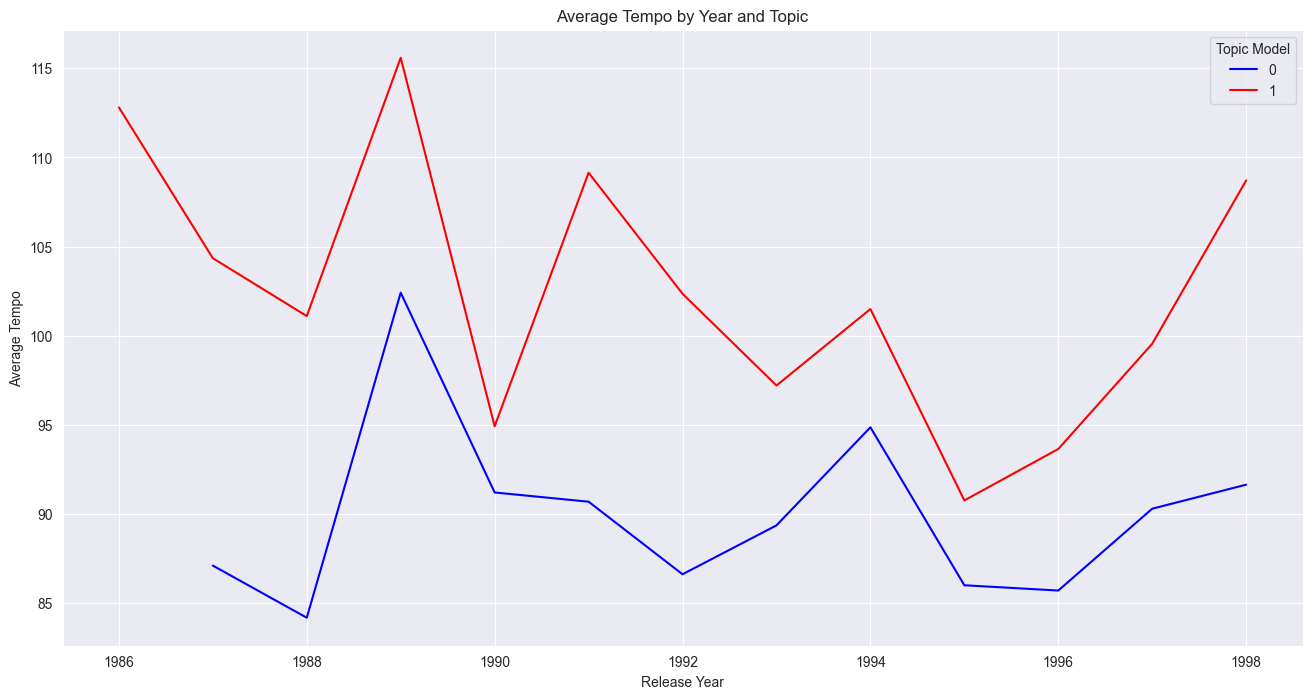

In [10]:
# Calculate the mean tempo for each Coast and Release Year
average_tempo = df_topics.groupby(['Topic Model', 'Release Year'])['Tempo1'].mean().reset_index()

colors = {
    0: 'blue',
    1: 'red',
}

# Set up the figure with a larger size
plt.figure(figsize=(16, 8))  # Width, height in inches

# Plot each coast's average tempo over the years
for topic, color in colors.items():
    # Select the subset of the data for the current coast
    subset = average_tempo[average_tempo['Topic Model'] == topic]

    # Ensure the data is sorted by year (important if the data isn't sorted in the dataframe)
    subset = subset.sort_values('Release Year')

    # Plotting
    plt.plot(subset['Release Year'], subset['Tempo1'], label=topic, color=color)

# Add legend, labels, and title
plt.legend(title='Topic Model')
plt.xlabel('Release Year')
plt.ylabel('Average Tempo')
plt.title('Average Tempo by Year and Topic')
plt.grid(True)  # Optionally add a grid for easier visualization

# Show the plot
plt.show()

<b>Average Tempo By Coast and Overall Average Over Years</b>

In [14]:
df['Release Year'] = pd.to_numeric(df['Release Year'], errors='coerce')

In [15]:
average_tempo_by_coast_year = df.groupby(['Release Year', 'Coast'])['Tempo1'].mean().reset_index()
overall_mean_tempo = df.groupby('Release Year')['Tempo1'].mean().reset_index()
overall_mean_tempo.rename(columns={'Tempo1': 'Overall Average Tempo'}, inplace=True)

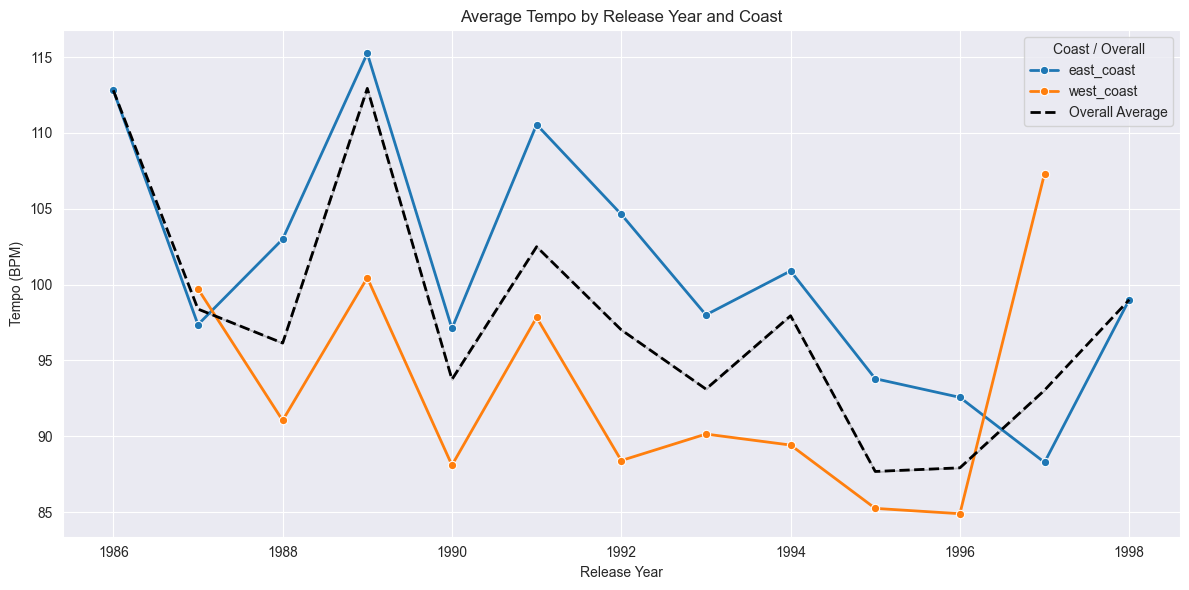

In [16]:
merged = average_tempo_by_coast_year.merge(overall_mean_tempo, on='Release Year')

plt.figure(figsize=(12, 6))

# Plot average tempo by coast
sns.lineplot(data=merged, x='Release Year', y='Tempo1', hue='Coast', marker='o', linewidth=2)

# Plot overall average tempo
sns.lineplot(data=merged, x='Release Year', y='Overall Average Tempo',
             color='black', linestyle='--', label='Overall Average', linewidth=2)

plt.title('Average Tempo by Release Year and Coast')
plt.ylabel('Tempo (BPM)')
plt.xlabel('Release Year')
plt.legend(title='Coast / Overall')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Count number of songs per coast per year
song_counts = df.groupby(['Release Year', 'Coast']).size().reset_index(name='Count')
# Merge counts into your average tempo DataFrame
average_with_counts = average_tempo_by_coast_year.merge(song_counts, on=['Release Year', 'Coast'])

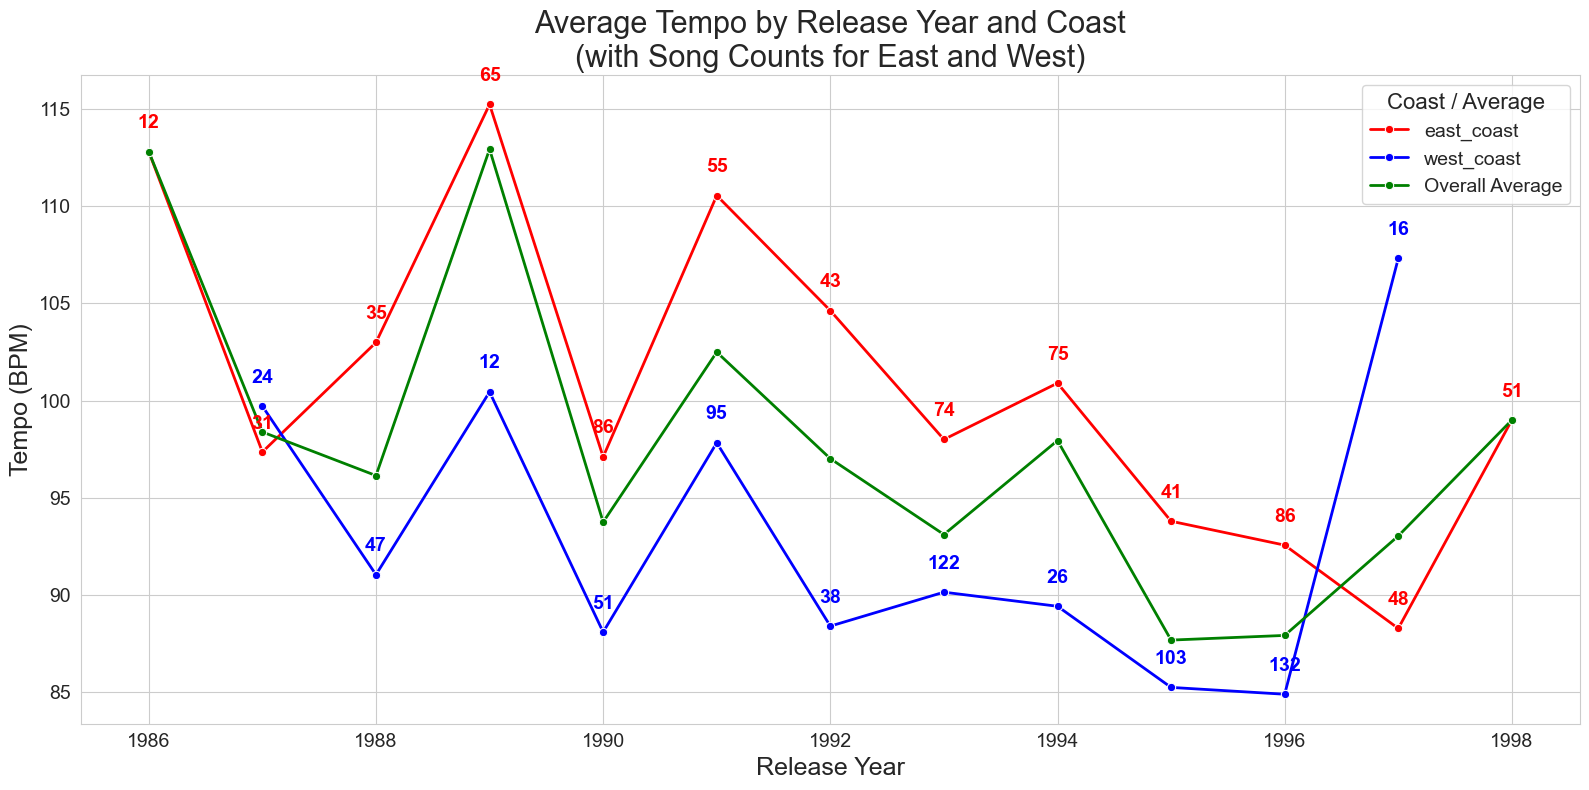

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare the data
avg_tempo = df.groupby(['Release Year', 'Coast'])['Tempo1'].mean().reset_index()
counts = df.groupby(['Release Year', 'Coast']).size().reset_index(name='Count')
overall_avg = df.groupby('Release Year')['Tempo1'].mean().reset_index()
overall_avg.rename(columns={'Tempo1': 'Overall Average Tempo'}, inplace=True)

# Merge coast data with counts
merged = avg_tempo.merge(counts, on=['Release Year', 'Coast'])

# Merge overall average with coast data for shared x-axis
plot_data = merged.merge(overall_avg, on='Release Year')

# Set white background style
sns.set_style("whitegrid")

# Set up the figure
plt.figure(figsize=(16, 8))

# Plot East & West tempo lines
sns.lineplot(data=plot_data, x='Release Year', y='Tempo1', hue='Coast',
             marker='o', linewidth=2, palette={'east_coast': 'red', 'west_coast': 'blue'})

# Plot overall average line (no hue)
sns.lineplot(data=plot_data.drop_duplicates(subset='Release Year'),
             x='Release Year', y='Overall Average Tempo',
             color='green', linestyle='-', marker='o', label='Overall Average', linewidth=2)

# Add count numbers in red/blue above each point for East/West only
for _, row in plot_data.iterrows():
    color = 'red' if row['Coast'] == 'east_coast' else 'blue'
    plt.text(row['Release Year'], row['Tempo1'] + 1, str(row['Count']),
             ha='center', va='bottom', fontsize=14, color=color, fontweight='bold')

# Customize plot
plt.title('Average Tempo by Release Year and Coast\n(with Song Counts for East and West)', fontsize=22)
plt.xlabel('Release Year', fontsize=18)
plt.ylabel('Tempo (BPM)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Coast / Average', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('../Plots/avg_tempo_by_year_coast.png')
plt.show()

<b>Significance tests</b>

In [13]:
# Global ttest
from scipy.stats import ttest_ind

east_all = df[df['Coast'] == 'east_coast']['Tempo1']
west_all = df[df['Coast'] == 'west_coast']['Tempo1']

# Perform t-test
t_stat, p_val = ttest_ind(east_all, west_all, equal_var=False)

print(f"Global t-test:")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Significant difference in tempo between East and West Coast (globally).")
else:
    print("❌ No significant difference in tempo between East and West Coast (globally).")


Global t-test:
T-statistic: 7.107, p-value: 0.0000
✅ Significant difference in tempo between East and West Coast (globally).


In [14]:
# Per year ttest
from scipy.stats import ttest_ind
per_year_results = []

for year in sorted(df['Release Year'].unique()):
    east = df[(df['Release Year'] == year) & (df['Coast'] == 'east_coast')]['Tempo1']
    west = df[(df['Release Year'] == year) & (df['Coast'] == 'west_coast')]['Tempo1']

    if len(east) > 1 and len(west) > 1:
        t_stat, p_val = ttest_ind(east, west, equal_var=False)
        per_year_results.append({
            'Year': year,
            'East Mean Tempo': east.mean(),
            'West Mean Tempo': west.mean(),
            'p-value': p_val,
            'Significant (p<0.05)': p_val < 0.05
        })

# Display results
per_year_df = pd.DataFrame(per_year_results)

In [16]:
# Print first few results nicely
print(per_year_df.round(3).to_string(index=False))

 Year  East Mean Tempo  West Mean Tempo  p-value  Significant (p<0.05)
 1987           97.360           99.717    0.772                 False
 1988          102.993           91.048    0.053                 False
 1989          115.238          100.450    0.094                 False
 1990           97.107           88.095    0.017                  True
 1991          110.551           97.834    0.010                  True
 1992          104.632           88.402    0.010                  True
 1993           98.005           90.148    0.023                  True
 1994          100.902           89.423    0.013                  True
 1995           93.798           85.250    0.010                  True
 1996           92.568           84.899    0.003                  True
 1997           88.283          107.314    0.072                 False
